<a href="https://colab.research.google.com/github/AanchalA/MakeMore-with-Andrej-Karpathy/blob/main/MicroGrad_AutoGrad_Engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install graphviz >> /dev/null

In [ ]:
import math
import random
import numpy as np
from graphviz import Digraph
from matplotlib.pyplot import plot

%matplotlib inline

In [ ]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self._op = _op
        self.grad = 0.0                 ## Initilizing gradient to 0
        self.data = data
        self.label = label
        self._prev = set(_children)
        self._backward = lambda: None


    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad}, label={self.label})"


    def __add__(self, other):                                               # __add__ can be used as + operator
        other = other if isinstance(other, Value) else Value(other)         # Wrapping integers as Value objects
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad         ## Accmulating gradients with '+=' in case the same input is used multiple times in the equation
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out


    def __radd__(self, other):              ## other + self
        return self + other


    def __mul__(self, other):                                               # x * y ==> x.__mul__(y) ==> self.__mul__(other)
        other = other if isinstance(other, Value) else Value(other)         # Wrapping integers as Value objects
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out


    def __rmul__(self, other): # other * self  ==> Reverse Multiplication (other * self ==> self * other)
        return self * other


    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only supporting int/float powers for now."
        out = Value(self.data ** other, (self, ), f'**{other}')

        def _backward():
            self.grad += (other * self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out


    def __truediv__(self, other):       ## self/other ==> self * (1/other) ==> self * (other ** -1)
        return self * other ** -1


    def __rtruediv__(self, other):      ## other / self
        return other * self**-1


    def __neg__(self):                  ## -self
        return self * -1


    def __sub__(self, other):           ## self - other
        return self + (-other)          ## Addition of a negation


    def __rsub__(self, other):          ## other - self
        return (-self) + other


    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad                       ### Derivative of e^x = e^x
        out._backward = _backward
        return out


    def tanh(self):
        n = self.data
        tan_h = (math.exp(2 * n) - 1) / (math.exp(2 * n) + 1)
        out = Value(tan_h, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - tan_h ** 2) * out.grad
        out._backward = _backward
        return out


    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward
        return out


    def backward(self):
        # topological order/sort all of the children in the graph
        # Laying out all the nodes such that all the edges go only left to right.
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)          ## The root node gets added to topo list

        # # AutoGrad
        self.grad = 1.0                 ## Setting the gradient of root to 1
        build_topo(self)

        for node in reversed(topo):
            node._backward()

In [ ]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges


def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [ ]:
class Module:

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []


class Neuron(Module):

    def __init__(self, nin):                # nin - number of inputs
        self.w = [Value(random.uniform(-1, 1), label=f'w_{i}') for i in range(nin)]             # Weight initilization for each input
        self.b = Value(random.uniform(-1, 1), label='b')


    def __call__(self, x):
        activation = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = activation.tanh()                 ## isinstance(activation, Value) --> True
        return out


    def parameters(self):
        return self.w + [self.b]


    def __repr__(self):
        return f"Neuron({len(self.w)})"



class Layer(Module):

    def __init__(self, nin, nout):          ## nin - number of inputs, nout - number of neurons/units in a layer
        self.neurons = [Neuron(nin) for _ in range(nout)]


    def __call__(self, x):
        outs = [n(x) for n in self.neurons]             ## Applying forwardpass on each of the neurons in a layer
        return outs[0] if len(outs) == 1 else outs


    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"



class MLP(Module):

    def __init__(self, nin, nouts=list()):          ## nouts - list of number of neurons in each layer. len(nouts) = # of layers
        sz = [nin] + nouts      ## [nin, nouts[0], nouts[1], ..., nouts[-1]]
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]            ## Layer creation


    def __call__(self, x):
        for layer in self.layers:
            # print(layer)
            x = layer(x)                                ## Layer.__call__() -- Calling the layers sequentially
        return x


    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

# Example 1

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
f = Value(-2.0, label='f')

In [ ]:
e = a * b; e.label='e'
d = e + c; d.label='d'
L = d * f; L.label='L'

In [ ]:
L.data, L._prev, L._op

In [ ]:
# # Local Derivatives
# L.grad = 1.0
# d.grad = f.data
# f.grad = d.data
# c.grad = 1.0
# e.grad = 1.0
# a.grad = b.data
# b.grad = a.data

In [ ]:
# Calculating Actual Derivatives of Loss wrt to all the weights

L.grad = 1.0
d.grad = f.data * L.grad
f.grad = d.data * L.grad
c.grad = 1.0 * d.grad
e.grad = 1.0 * d.grad
a.grad = b.data * e.grad
b.grad = a.data * e.grad

In [ ]:
# BackProp - Updating weights

a.data = a.data + 0.01 * a.grad
b.data = b.data + 0.01 * b.grad
c.data = c.data + 0.01 * c.grad
f.data = f.data + 0.01 * f.grad

In [ ]:
# Recalculating

e = a * b; e.label='e'
d = e + c; d.label='d'
L = d * f; L.label='L'          ## Updated Value of L
L.data

In [ ]:
draw_dot(L)

# Example 2

In [ ]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [ ]:
# # Manual Derivatives
# o.grad = 1.0
# n.grad = (1 - o.data**2) * o.grad
# b.grad = 1.0 * n.grad
# x1w1x2w2.grad = 1.0 * n.grad
# x1w1.grad = 1.0 * x1w1x2w2.grad
# x2w2.grad = 1.0 * x1w1x2w2.grad
# w1.grad = x1.data * x1w1.grad
# w2.grad = x2.data * x2w2.grad
# x1.grad = w1.data * x1w1.grad
# x2.grad = w2.data * x2w2.grad

In [ ]:
# # AutoGrad
# o.grad = 1.0
# o._backward()
# n._backward()
# # b._backward()             ## Nothing happans as b is a leaf node and _backward for leaf is lambda: self
# x1w1x2w2._backward()
# x1w1._backward()
# x2w2._backward()
# # w1._backward()            ## Nothing happans as w1 is a leaf node and _backward for leaf is lambda: self
# # w2._backward()            ## Nothing happans as w2 is a leaf node and _backward for leaf is lambda: self
# # x1._backward()            ## Nothing happans as x1 is a leaf node and _backward for leaf is lambda: self
# # x2._backward()            ## Nothing happans as x2 is a leaf node and _backward for leaf is lambda: self

In [ ]:
# # # AutoGrad
# o.grad = 1.0
# build_topo(o)

# for node in reversed(topo):
#     node._backward()

In [ ]:
o.backward()

In [ ]:
draw_dot(o)

# Example 3

In [ ]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'        ## Gradiant of a is accumulated "1 + 1"
b.backward()

draw_dot(b)

# Example 4

In [ ]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'
f.backward()

draw_dot(f)

# Example 5 - Reverse Addition

In [ ]:
a = Value(2.0, label='a')
b = a + 3; b.label = 'b'
c = 6 + b; c.label = 'c'

c.backward()
draw_dot(c)

# Example 6 - Reverse Multiplication

In [ ]:
a = Value(2.0, label='a')
b = a * 3; b.label = 'b'
c = 6 * b; c.label = 'c'

c.backward()
draw_dot(c)

# Example 7 - Division

In [ ]:
a = Value(2.0, label='a')
b = Value(4.0, label='b')
c = a / b; c.label = 'c'                #### a/b ==> a*(1/b) ==> a*(b**-1)

c.backward()
draw_dot(c)

# Example 8 - Subtraction

In [ ]:
a = Value(10.0, label='a')
b = a - 3; b.label = 'b'
c = 14 - b; c.label = 'c'

c.backward()
draw_dot(c)

# Example 9 - TanH from scratch

In [ ]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

# -----------------------
# o = n.tanh();
e = (2 * n).exp()
o = (e - 1) / (e + 1)
o.label = 'o'
# -----------------------

o.backward()

In [ ]:
draw_dot(o)

# Example 10 - With PyTorch

In [ ]:
import torch

In [ ]:
# inputs x1, x2
x1 = torch.Tensor([2.0]).double();                      x1.requires_grad = True
x2 = torch.Tensor([0.0]).double();                      x2.requires_grad = True

# Weights w1, w2
w1 = torch.Tensor([-3.0]).double();                     w1.requires_grad = True
w2 = torch.Tensor([1.0]).double();                      w2.requires_grad = True

# bias of the neuron
b = torch.Tensor([6.8813735870195432]).double();        b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('--------------')
print(f'x2: {x2.grad.item()}')
print(f'w2: {w2.grad.item()}')
print(f'x1: {x1.grad.item()}')
print(f'w1: {w1.grad.item()}')

# Example 11

In [ ]:
x = [2.0, 3.0, -1.0]
n = MLP(len(x), [4, 4, 1])
n(x)

Value(data=0.020137488200238713, grad=0.0, label=)

In [ ]:
n.parameters()

[Value(data=-0.16938232193633795, grad=0.0, label=w_0),
 Value(data=-0.2804295702267179, grad=0.0, label=w_1),
 Value(data=0.369333141559985, grad=0.0, label=w_2),
 Value(data=0.7037182824605184, grad=0.0, label=b),
 Value(data=0.4786006799635536, grad=0.0, label=w_0),
 Value(data=-0.8124107526336157, grad=0.0, label=w_1),
 Value(data=0.586149258757604, grad=0.0, label=w_2),
 Value(data=-0.8050523659842852, grad=0.0, label=b),
 Value(data=-0.1813218601846991, grad=0.0, label=w_0),
 Value(data=0.29596332283102833, grad=0.0, label=w_1),
 Value(data=0.006647963089792652, grad=0.0, label=w_2),
 Value(data=0.9981448442811967, grad=0.0, label=b),
 Value(data=0.7159381261210105, grad=0.0, label=w_0),
 Value(data=-0.8789166657315906, grad=0.0, label=w_1),
 Value(data=0.4534247904865847, grad=0.0, label=w_2),
 Value(data=-0.5120068085390308, grad=0.0, label=b),
 Value(data=0.874031758235509, grad=0.0, label=w_0),
 Value(data=0.0030419465729176753, grad=0.0, label=w_1),
 Value(data=0.97156122039

In [ ]:
len(n.parameters())

41

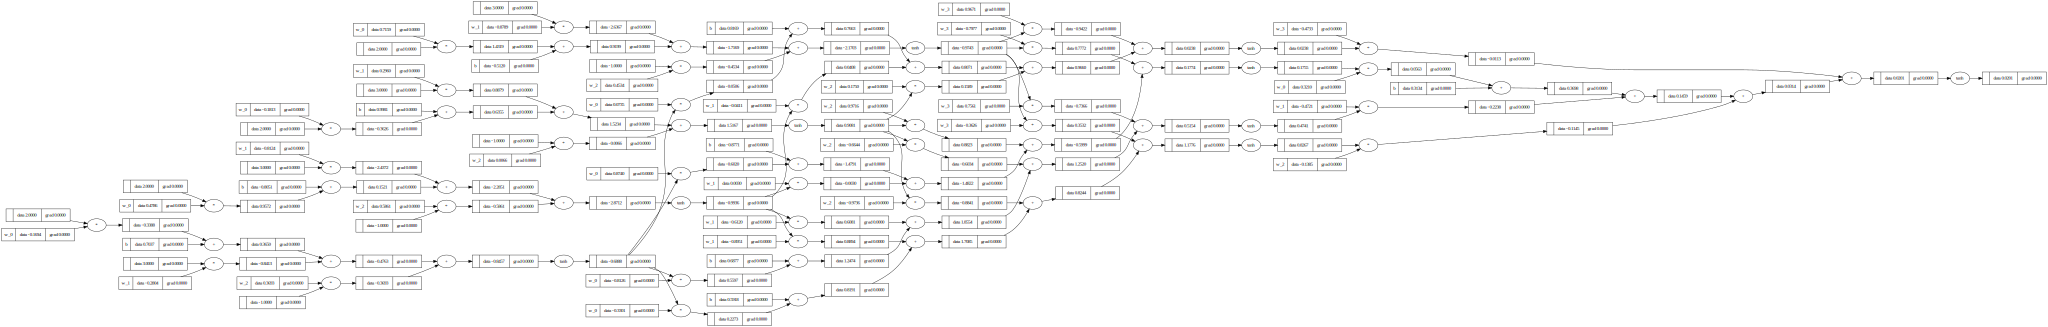

In [ ]:
draw_dot(n(x))

# Example 12 - MLP

In [ ]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]         ## Desired Targets

In [ ]:
n = MLP(len(xs[0]), [4, 4, 1])

In [ ]:
len(n.parameters())

41

In [ ]:
EPOCHS = 400
LEARNING_RATE = 0.03

In [ ]:
for k in range(EPOCHS):

    # FORWARD PASS
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])

    # BACKWARD PASS
    for p in n.parameters():
        p.grad = 0.0            ## Resetting all gradients to zero.
    loss.backward()

    # PARAMETERS UPDATE
    for p in n.parameters():
        p.data += -LEARNING_RATE * p.grad

    if k % 10 == 0 or k==EPOCHS-1:
        print(f'EPOCH {k}: {loss.data}')

EPOCH 0: 0.0032831394195864177
EPOCH 10: 0.003177832936641659
EPOCH 20: 0.0030788745665980286
EPOCH 30: 0.002985713838824465
EPOCH 40: 0.0028978617281316503
EPOCH 50: 0.002814882349376481
EPOCH 60: 0.002736385959890882
EPOCH 70: 0.002662023036123247
EPOCH 80: 0.002591479237308492
EPOCH 90: 0.002524471105292683
EPOCH 100: 0.002460742378224229
EPOCH 110: 0.0024000608184636804
EPOCH 120: 0.0023422154731023164
EPOCH 130: 0.002287014299929914
EPOCH 140: 0.002234282103330323
EPOCH 150: 0.002183858734003062
EPOCH 160: 0.0021355975140716125
EPOCH 170: 0.0020893638553981905
EPOCH 180: 0.0020450340440632863
EPOCH 190: 0.0020024941682018297
EPOCH 200: 0.001961639169891169
EPOCH 210: 0.00192237200469666
EPOCH 220: 0.001884602894906847
EPOCH 230: 0.001848248664520284
EPOCH 240: 0.0018132321457511023
EPOCH 250: 0.0017794816482558126
EPOCH 260: 0.001746930483497765
EPOCH 270: 0.0017155165376936895
EPOCH 280: 0.001685181887661884
EPOCH 290: 0.0016558724546363451
EPOCH 300: 0.001627537691749103
EPOCH 3

In [ ]:
ypred

[Value(data=0.9875553113833253, grad=-0.024889377233349386, label=),
 Value(data=-0.9925475910016338, grad=0.014904817996732378, label=),
 Value(data=-0.9743468289147733, grad=0.05130634217045338, label=),
 Value(data=0.9771469286807263, grad=-0.04570614263854744, label=)]

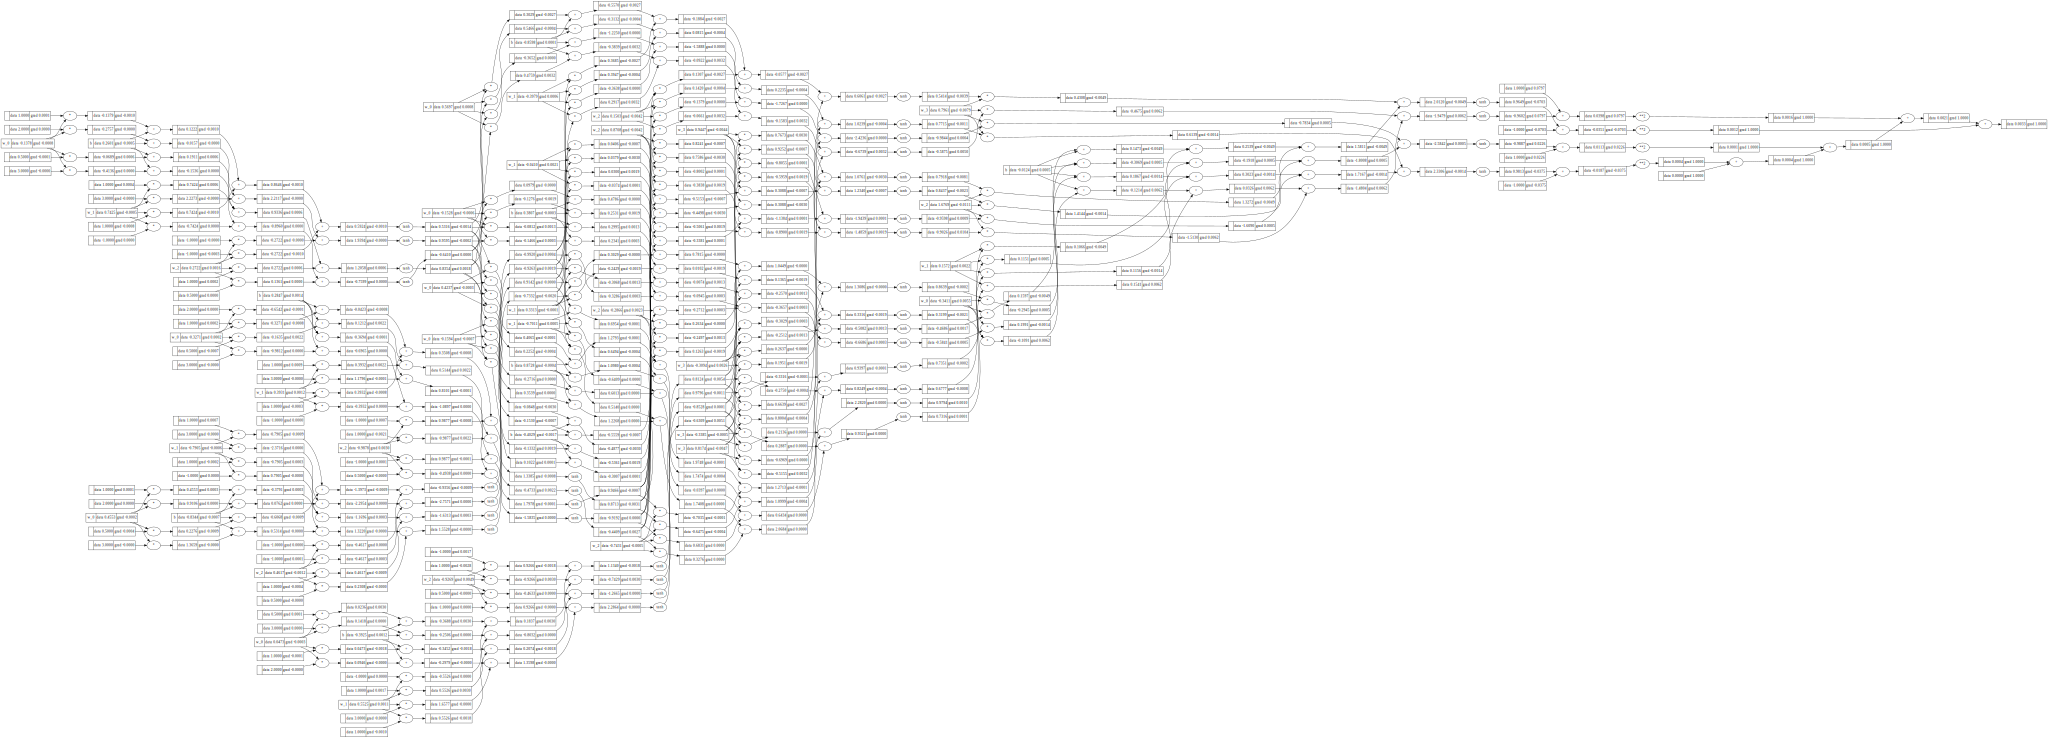

In [ ]:
draw_dot(loss)